In [1]:
"""
Data Loading.
"""

'\nData Loading.\n'

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
%%time
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

CPU times: total: 59.6 s
Wall time: 59.9 s


In [4]:
%%time
signals_path = "./Data/Signals/KCM_signals.shp"
signals = gpd.read_file(signals_path)

CPU times: total: 1.27 s
Wall time: 1.32 s


In [5]:
%%time
kc_streets_path = "./Data/Seattle_Streets/KCM_Streets.shp"
kc_streets = gpd.read_file(kc_streets_path)

CPU times: total: 3min 51s
Wall time: 3min 52s


In [6]:
%%time
kcm_routes_path = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
kcm_routes = gpd.read_file(kcm_routes_path)

CPU times: total: 1.48 s
Wall time: 1.5 s


In [7]:
%%time
accel_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(accel_prof_path, names=['time[s]', 'accel.[g]'])

CPU times: total: 31.2 ms
Wall time: 39.4 ms


In [8]:
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [9]:
%%time
all_stops = stops.copy()

all_signals = signals['geometry'].reset_index(drop = True)

all_limits = kc_streets[['geometry','SPEED_LIM']]


CPU times: total: 93.8 ms
Wall time: 99.3 ms


(47.0, 47.8)

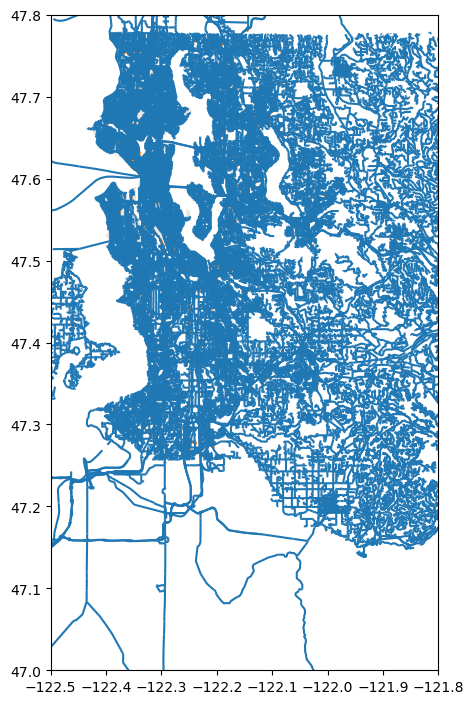

In [10]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
all_limits.plot(ax=ax, markersize=1)
all_signals.plot(ax = ax, c="tab:orange", markersize=1)
ax.set_xlim(-122.5, -121.8)
ax.set_ylim(47, 47.8)

# Landscape elevation +/= Road elevation - Vehicle dynamic models need the road elevation

In [11]:
route_list = [22, 101, 122,]
period_list = []
concat_val = []

In [25]:
kcm_routes['ROUTE_NUM'].unique()

array([ 22, 221,  24, 240, 245, 246, 249, 255, 257, 269,  27, 271,  28,
         3, 303,  31, 311,  32,  33,   1,  10, 101, 105, 106, 107,  11,
       111, 113, 118, 119,  12, 124, 125, 128,  13, 131, 132,  14, 148,
       150, 153, 168,  17, 177, 181, 182, 183, 187,   2, 208,  21, 212,
       599, 775, 102, 156, 193, 930, 542, 671, 672, 226, 241, 893, 915,
       907,  40, 673, 674, 906, 675, 676, 330, 331, 345, 346, 347, 348,
        36, 372,   4,  43,  44,  45,  48,   5,  50, 522, 545, 550, 554,
        56,  57,  60,  62,  65,  67,   7,  70,  73,  75, 773,   8,   9,
       901, 903, 914, 917, 973, 975,  98, 982, 984, 986, 987, 988, 989,
       994,  49, 556, 218, 981, 895, 630, 631,  96, 635, 204, 224, 627,
       629, 225, 239, 231, 250, 230, 162, 165, 184, 161, 160, 322,  20,
       302,  79, 566, 678], dtype=int64)

In [16]:
route_path = "./Data/Routes/Individual_Routes/rt22_pts.shp"
route_raw = gpd.read_file(route_path)
route_raw

,Id,ORIG_FID,SHAPE_Leng,Z,geometry
0,0,1,0.236717,324.449184,POINT (-122.38813 47.56295)
1,0,1,0.236717,324.591054,POINT (-122.38810 47.56295)
2,0,1,0.236717,324.689024,POINT (-122.38808 47.56295)
3,0,1,0.236717,324.780330,POINT (-122.38806 47.56295)
4,0,1,0.236717,324.841638,POINT (-122.38803 47.56295)
...,...,...,...,...,...
9714,0,1,0.236717,323.775553,POINT (-122.38813 47.56285)
9715,0,1,0.236717,347.445554,POINT (-122.38813 47.56288)
9716,0,1,0.236717,354.685970,POINT (-122.38813 47.56290)
9717,0,1,0.236717,324.268711,POINT (-122.38813 47.56292)


In [17]:
kc_elevation = gpd.read_file("./Data/Elevation_Data/KC_Elev.shp")

In [18]:
kc_elevation[kc_elevation.area_name == 'King County']

,OBJECTID,SERIAL_ID,area_name,DATA_SOURC,DESCRIP,TILESUFFIX,VINTAGE,Shape_Leng,Shape_Area,geometry
39,40,140,King County,nv21,NV5 Geospatial 2021,nv21,2021,3.828027e+06,6.359013e+10,"MULTIPOLYGON (((-122.38728 47.66213, -122.3872..."
